In [15]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib notebook
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend
sm_refpoints = ps.StanModel(file="nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fe0f7e987f18faca8aa83cd73157fac NOW.


In [2]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

In [3]:
n_ref = 200
ref_points = npr.choice(Nobs,n_ref,replace=False)
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = X[:,ref_points]
Y_train = Y[:,train]

<IPython.core.display.Javascript object>


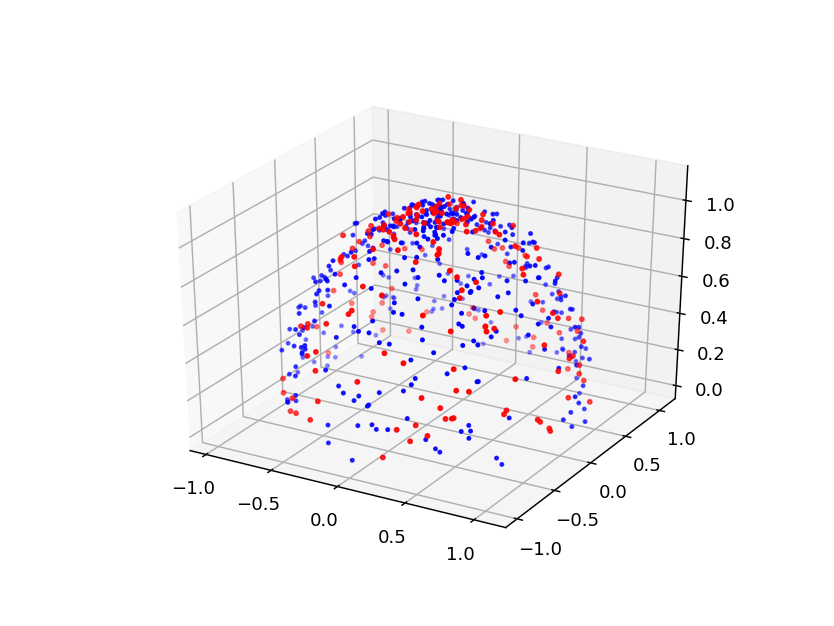

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Y_train[0], ys=Y_train[1], zs=Y_train[2], zdir='z', s=3, c=None, depthshade=True, color="blue")
ax.scatter(xs=Y_ref[0], ys=Y_ref[1], zs=Y_ref[2], zdir='z', s=5, c=None, depthshade=True, color="red")
plt.show()

In [6]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=2, 
                      out_dim=3, 
                      hidden_dim=50,
                      n_ref=n_ref,
                      y=Y_train.transpose(), 
                      y_ref=Y_ref.transpose(),
                      X_ref=X_ref.transpose())

In [7]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


360.44 minutes to run
Inference for Stan model: anon_model_3fe0f7e987f18faca8aa83cd73157fac.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]           -1.11    0.66   0.94  -1.95  -1.78  -1.47  -0.38   0.55      2  14.71
X[2,1]           -0.01    0.41   0.59   -0.7  -0.47  -0.16    0.4   1.03      2  13.72
X[3,1]           -0.25    0.32   0.46  -0.85  -0.68  -0.43   0.25   0.34      2   6.22
X[4,1]           -0.03    0.88   1.25  -2.29  -0.91   0.61   0.67   1.01      2  17.59
X[5,1]            0.84     0.7   0.99  -0.62  -0.05    0.8   1.86    2.0      2  16.01
X[6,1]           -0.99    0.71    1.0  -1.87  -1.75   -1.4  -0.15   0.76      2  18.51
X[7,1]            1.22    0.53   0.75   0.54   0.72   0.84   1.87   2.55      2  10.63
X[8,1]            0.68    0.64    0.9  -0.34   -0.2   0.53    1.6    1.7      2  16.41
X[9,1]  

In [8]:
trace = fit_refpoints.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

In [9]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

<IPython.core.display.Javascript object>


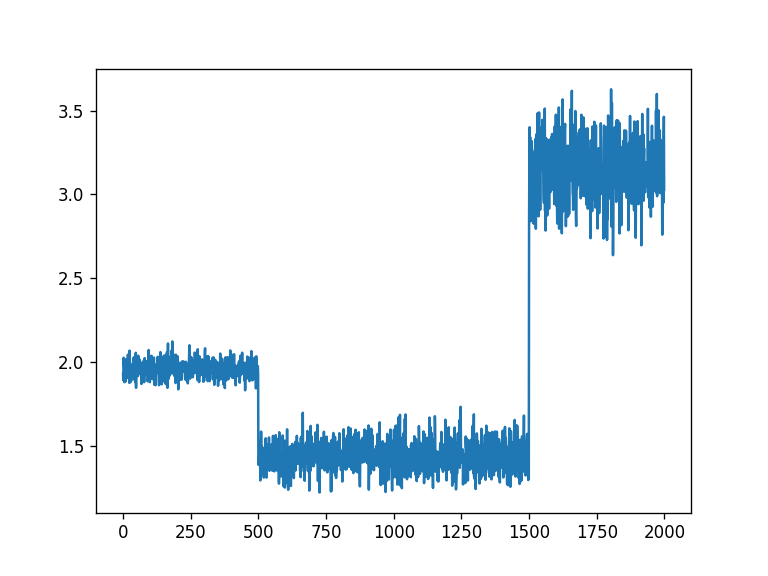

In [16]:
plt.plot(pw_dist_matrix[0,1])

### Local linear embedding for reference points:

In [3]:
embedding = LocallyLinearEmbedding(n_components=2)
Y_embedded = embedding.fit_transform(Y)

In [5]:
ref_points = np.arange(50)
n_ref = len(ref_points)
Nobs = np.shape(Y)[0]
train = np.setdiff1d(np.arange(Nobs), ref_points)
y_ref = Y[ref_points]
X_ref = np.zeros((n_ref,2))
for i in range(n_ref) :
    X_ref[i] = Y_embedded[i]

In [7]:
Y_new = np.zeros(np.shape(Y))
for i in range(n_ref) :
    Y_new[i] = Y[ref_points[i]]
Y_new[n_ref::] = Y[np.setdiff1d(np.arange(Nobs), ref_points)]

In [8]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=2, 
                      out_dim=3, 
                      hidden_dim_1=50,
                      n_ref=n_ref,
                      y=Y_new[n_ref:], 
                      y_ref=Y_new[:n_ref],
                      X_ref=X_ref)

In [ ]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=4,chains=4,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

In [13]:
pw_dist_obs = np.genfromtxt('GeodesicDistance/pw_dist.txt', delimiter=',')